In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from botorch.utils.transforms import unnormalize, normalize
from botorch.models import SingleTaskGP
from botorch.models.model_list_gp_regression import ModelListGP
from gpytorch.mlls.sum_marginal_log_likelihood import SumMarginalLogLikelihood
from gpytorch.mlls.sum_marginal_log_likelihood import ExactMarginalLogLikelihood
from botorch import fit_gpytorch_mll
from botorch.models.transforms.outcome import Standardize
from torch.optim import Adam

from gpytorch.likelihoods import DirichletClassificationLikelihood

/Users/gouravkumbhojkar/miniconda3/envs/botorch/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
filename = r'../../data/olhs_run1.xlsx'
x_pd = pd.read_excel(filename, sheet_name='Initial Design (OLHS)', header=[0,1], index_col=[0])
y_pd = pd.read_excel(filename, sheet_name='bo_data', header=[0,1], index_col=[0])

dtype=torch.double

x = torch.tensor(x_pd.values, dtype=dtype)
mfg = torch.tensor(y_pd['Manufacturability'].values, dtype=torch.long)

x_bounds = np.array([[2000, 10000], [0, 100], [0, 40], [5000, 15000], [80, 100], [0,100], [60, 100], [70, 100]])
x_bounds = torch.tensor(x_bounds.T, dtype=dtype)

x = normalize(x, bounds=x_bounds)

Dirichlet likelihood function only used to generate the transformed outputs

In [3]:
likl = DirichletClassificationLikelihood(targets=mfg.squeeze(), alpha_epsilon=1e-4, learn_additional_noise=False)
model = SingleTaskGP(train_X=x, train_Y=likl.transformed_targets.T.double(), outcome_transform=Standardize(m=2))
mll = ExactMarginalLogLikelihood(model.likelihood, model)
mll.to(x)

ExactMarginalLogLikelihood(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (noise_prior): GammaPrior()
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (model): SingleTaskGP(
    (likelihood): GaussianLikelihood(
      (noise_covar): HomoskedasticNoise(
        (noise_prior): GammaPrior()
        (raw_noise_constraint): GreaterThan(1.000E-04)
      )
    )
    (mean_module): ConstantMean()
    (covar_module): ScaleKernel(
      (base_kernel): MaternKernel(
        (lengthscale_prior): GammaPrior()
        (raw_lengthscale_constraint): Positive()
      )
      (outputscale_prior): GammaPrior()
      (raw_outputscale_constraint): Positive()
    )
    (outcome_transform): Standardize()
  )
)

In [4]:
fit_gpytorch_mll(mll)

ExactMarginalLogLikelihood(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (noise_prior): GammaPrior()
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (model): SingleTaskGP(
    (likelihood): GaussianLikelihood(
      (noise_covar): HomoskedasticNoise(
        (noise_prior): GammaPrior()
        (raw_noise_constraint): GreaterThan(1.000E-04)
      )
    )
    (mean_module): ConstantMean()
    (covar_module): ScaleKernel(
      (base_kernel): MaternKernel(
        (lengthscale_prior): GammaPrior()
        (raw_lengthscale_constraint): Positive()
      )
      (outputscale_prior): GammaPrior()
      (raw_outputscale_constraint): Positive()
    )
    (outcome_transform): Standardize()
  )
)

In [5]:
model.eval()

with torch.no_grad():
    posterior = model.posterior(x)
    pred_mean = posterior.mean
pred_mean

tensor([[-13.3763,  -0.7857],
        [ -1.2660, -12.8960],
        [ -1.2760, -12.8860],
        [ -1.2722, -12.8898],
        [-13.4369,  -0.7251],
        [-13.4353,  -0.7267],
        [-13.3966,  -0.7654],
        [-13.3777,  -0.7843],
        [-13.3980,  -0.7640],
        [-13.4172,  -0.7448],
        [-13.3916,  -0.7704],
        [-13.4071,  -0.7549],
        [-13.4192,  -0.7428],
        [-13.4326,  -0.7294],
        [ -1.2345, -12.9275],
        [-13.4365,  -0.7255],
        [-13.4678,  -0.6942],
        [ -1.3611, -12.8009],
        [-13.4563,  -0.7057],
        [ -1.2375, -12.9245]], dtype=torch.float64)

In [6]:
samples = posterior.sample(torch.Size((256,))).exp()
probabilities = (samples / samples.sum(-1, keepdim=True)).mean(0)

In [7]:
probabilities

tensor([[1.6146e-04, 9.9984e-01],
        [9.9963e-01, 3.6739e-04],
        [9.9943e-01, 5.6714e-04],
        [9.9924e-01, 7.6362e-04],
        [1.0644e-04, 9.9989e-01],
        [5.1239e-05, 9.9995e-01],
        [1.2651e-04, 9.9987e-01],
        [1.3309e-04, 9.9987e-01],
        [9.7779e-05, 9.9990e-01],
        [1.7531e-04, 9.9982e-01],
        [1.6116e-04, 9.9984e-01],
        [1.3185e-04, 9.9987e-01],
        [3.5312e-05, 9.9996e-01],
        [5.9117e-05, 9.9994e-01],
        [9.9975e-01, 2.4600e-04],
        [1.2884e-04, 9.9987e-01],
        [4.0486e-05, 9.9996e-01],
        [9.9977e-01, 2.2788e-04],
        [1.6916e-04, 9.9983e-01],
        [9.9983e-01, 1.7062e-04]], dtype=torch.float64)

In [8]:
pred_mean.T.max(0)[1]

tensor([1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0])

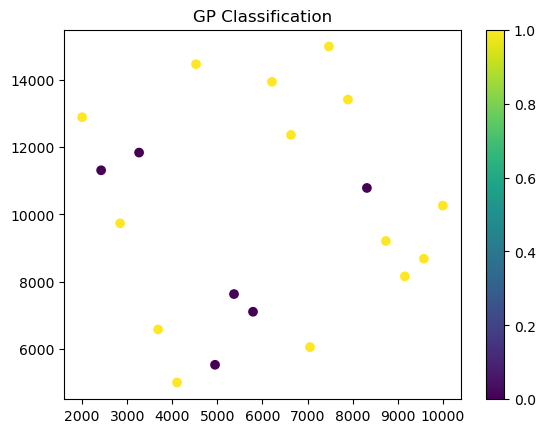

In [11]:
x1_plt = x_pd['Block 1 (Hydrophobic) [End Segment]', 'Block Size'].values
x2_plt = x_pd['Block 2 (Hydrophilic) [Middle Segment]', 'Block Size'].values
class_pred = pred_mean.T.max(0)[1]
plt.scatter(x1_plt, x2_plt, c = class_pred)
plt.colorbar()
plt.title('GP Classification')
plt.show()